# Genoma Class


In [2]:
from multiprocessing.sharedctypes import copy
from quopri import decodestring
from random import *
import random
import math
from itertools import product
import graphviz

class Genoma:
    def __init__(self, numberOfGenes = 60, nInputs = 4,nOutputs = 1, rateMutation = 0.10):
        self.genotipo = []
        self.copyGenotipo = []
        self.numberOfGenes = numberOfGenes
        self.faultChance = 0
        self.nInputs = nInputs
        self.nOutputs = nOutputs
        self.possiblesOutputs = 2**nInputs
        self.fitness = 0.0
        self.noiseFitness = 0.0
        self.rateMutation = rateMutation
        self.deadGenesRate = 0.6
        self.activeGenesRate = 0.4
        self.flagDeadActive = 0
        self.indexDeadGenes = []
        self.indexActiveGenes = []
        self.Stochasticity = 0.003
        self.ToEvaluate = []

    def setFitness(self, fitness):
      self.fitness = fitness

    def setGenotipo(self, a):
      self.genotipo = a.copy()

    def setFaultChance(self,newFaultChance=0):
      self.faultChance = newFaultChance

    def setStochasticity(self, newStochasticity):
      self.Stochasticity = newStochasticity

    def setRateMutation(self, newRateMutation):    
      self.rateMutation = newRateMutation

    def getGenotypeActiveZone(self):
      # Return the numberid and the gene that is in active zone.
      # Return (numberId,Gene)
      # Return (int,str)
      if self.genotipo:
        self.identify_deadGenes()
        return [(i+self.nInputs,gene) for i,gene in enumerate(self.genotipo) if self.ToEvaluate[i]]
      else:
        return []
    
    def getActiveZoneLen(self):
       count = 0
       self.identify_deadGenes()
       for gene in self.ToEvaluate:
          if gene == True:
             count += 1
      
       return count

    def getGenotypeDeadZone(self):
      # Return the numberid and the gene that is in dead zone.
      # Return (numberId,Gene)
      # Return (int,str)
      if self.genotipo:
        self.identify_deadGenes()
        return [(i+self.nInputs,gene) for i,gene in enumerate(self.genotipo) if not self.ToEvaluate[i]]
      else:
        return []
    
    def fill_Initial_Genome(self):
        for i in range (0,self.numberOfGenes):
            self.genotipo.append("")

    def generate_parent(self):  

        self.fill_Initial_Genome()          # fill the genome with the rigth length
        
        for i in range(0,self.numberOfGenes):

            in1 = randint(0,i+self.nInputs-1)    # returns a number between 0 and n (PS: in randint() both inputs are included)
            in2 = randint(0,i+self.nInputs-1)    # returns a number between 0 and n (PS: in randint() both inputs are included)
        
            sin1 = str(in1)
            sin2 = str(in2)

            gene = sin1 +"-"+ sin2
            self.genotipo.pop(i)
            self.genotipo.insert(i, gene)

    def identify_deadGenes(self):
        self.ToEvaluate=[]
        for i in range (0,self.numberOfGenes-self.nOutputs):
          self.ToEvaluate.append(False)
        for i in range (0, self.nOutputs):
          self.ToEvaluate.append(True)

        p = self.numberOfGenes-1
        while p>=0:
          if self.ToEvaluate[p]:
            inputs = self.genotipo[p].split("-")
            input1 = int(inputs[0])
            input2 = int(inputs[1])
            x = input1 - self.nInputs
            y = input2 - self.nInputs
            if(x >= 0):
              self.ToEvaluate[x] = True
            if(y >= 0):
              self.ToEvaluate[y] = True

          p-=1
      
    def nandExpression(self,a,b):
      return "not("+a+" and "+b+")"

    def getLogicExpression(self):
      self.identify_deadGenes()
      p = self.numberOfGenes-1
      while p>=0:
        if self.ToEvaluate[p]:
          break
      return self.getNandActives(self.genotipo[p])
          
    def getNandActives(self,inputsGene):

      inputs = inputsGene.split("-")
      input1 = inputs[0]
      input2 = inputs[1]
      if(int(input1) - 2 < 0):
        if(int(input2) -2 < 0):
          return self.nandExpression(input1,input2)
        else:
          return self.nandExpression(input1,self.getNandActives(self.genotipo[int(input2) - 2]))
      else:
        if(int(input2) -2 < 0):
          return self.nandExpression(self.getNandActives(self.genotipo[int(input1) - 2]),input2)
        else:
          return self.nandExpression(self.getNandActives(self.genotipo[int(input1) - 2]),self.getNandActives(self.genotipo[int(input2) - 2]))

    def graphvizGenome(self,name):
        genome = self.getGenotypeActiveZone()
        # Create a graphviz Digraph
        f = graphviz.Digraph(filename="output/"+name)
        f.attr(rankdir="RL")  # Set direction to right-to-left for mirroring

        # Track which nodes are targets
        target_nodes = set()

        # Specify edges based on the relationships in the genome
        for tuple_item in genome:
            source_gene = f"G{tuple_item[0]}"
            target_genes = tuple_item[1].split('-')

            for target_gene_index in target_genes:
                if int(target_gene_index) > self.nInputs - 1:
                    target_gene = f"G{int(target_gene_index)}"
                    target_nodes.add(target_gene)
                    f.node(target_gene, shape='ellipse', color='black', style='filled', fillcolor='white')
                else:
                    target_gene = f"I{int(target_gene_index)}"
                    f.node(target_gene, shape='box', color='mediumturquoise', style='filled', fillcolor='paleturquoise')

        # Define the ranks explicitly
        f.attr(rank='same')
        for tuple_item in genome:
            source_gene = f"G{tuple_item[0]}"
            f.node(source_gene, shape='ellipse', color='mediumorchid', style='filled', fillcolor='plum')

            for target_gene_index in tuple_item[1].split('-'):
                if int(target_gene_index) > self.nInputs - 1:
                    target_gene = f"G{int(target_gene_index)}"
                else:
                    target_gene = f"I{int(target_gene_index)}"
                f.edge(source_gene, target_gene, dir='back')

        for node in target_nodes:
            if node not in set(source for _, target in genome for source in target_genes):
                f.node(node, shape='ellipse', color='black', fillcolor='white')

        # Save the graph to a file (e.g., in PNG format)
        f.render(format="eps", cleanup=True)
        f.render(format='png', cleanup=True)

    def xor(self, l):
        count = 0
        n = len(l)
        if(l[n] + l[n-1] == 1):
          return 1
        else :
          return 0

    def muxNand(self, l):
      len_l = len(l)
      selector_len = math.floor(math.log2(len_l))
      inputs = [str(x) for x in l[0:len_l - selector_len]]
      selector = [str(x) for x in l[len_l - selector_len:len_l]]

      selector_bin = ''.join(selector)
      selector_int = int(selector_bin, 2)

      return inputs[selector_int]

    def demuxNand(self,l):
      len_l = len(l)
      selector_len = math.ceil(math.log2(self.nOutputs))
      input = l[0]
      selector = [str(x) for x in l[1:len_l]]
      
      print(input,selector)
      selector_bin = ''.join(selector)
      selector_int = int(selector_bin, 2)
      print(selector_bin,selector_int)

    def gpiNand(self, l):      
      count = 0
      n = len(l)
      for i in range(0,n):
        if(l[i] == 1):
          count+=1

      if(count%2 == 0):
          return "0"
      else: 
          return "1"

    def fullAdderNand(self,l):
      # Preparing
      middle = int(len(l)/2) + 1
      input1 = [str(x) for x in l[1:middle]]
      input2 = [str(x) for x in l[middle:]]
      cIn = [str(l[0])]
      input1s = ''.join(input1) 
      input2s = ''.join(input2)
      cIns = ''.join(cIn)
      #print(input1s, input2s, cIns)
      # Logical Expressions
      sum = bin(int(input1s, 2) ^ int(input2s, 2) ^ int(cIns, 2))[2:]
      cOut = bin((int(input1s, 2) & int(input2s, 2)) | (int(input2s, 2) & int(cIns, 2)) | (int(input1s, 2) & int(cIns, 2)))[2:]
      sum_bits =str(sum) + str(cOut) 
      sum_bits_string = sum_bits.zfill(self.nOutputs)
      #print(sum_bits_string)
      # Returning
      return sum_bits_string

    def NAND(self,a,b):  ### NAND 1 1 1 0
        output = 1
        if a == 1 and b == 1:
            output = 0
        return output

    def NAND1(self, a, b): ### NAND1 1 1 1 1
      return 1

    def NAND2(self, a, b): ### NAND2 1 0 1 0
      return not(b)

    def NAND3(self, a, b): ### NAND3 1 1 0 0
      return not(a)

    def NAND4(self, a, b): ### NAND4 0 0 0 0
      return 0

    def NAND_defeitos (self, a, b):
      value = random.uniform(0,1)
      if value>(self.faultChance):
          output = 1
          if a == 1 and b == 1:
              output = 0
      else:
        ## Choose between the 4 types of error
        type_of_error = random.randint(0, 100)
        if type_of_error <= 44:
          output = self.NAND1(a, b) ## 44%
        elif type_of_error > 44 and type_of_error <= 66:
          output = self.NAND2(a, b) ## 22%
        elif type_of_error > 66 and type_of_error <= 88:
          output = self.NAND3(a, b) ## 22%
        else:
          output = self.NAND4(a, b) ## 12%
      return output

    def getCartesianProduct(self,l):
        CartesianProduct = [[]]
        for iterable in l:
          CartesianProduct = [a+[b] for a in CartesianProduct for b in iterable]
        return CartesianProduct

    def redundantCalcFitness(self,trys,GPINAND_ID):

        listGenome = []
        x = "2-3 2-0 0-0 2-5 5-1 8-6 1-3 9-1 4-2 11-10 4-11 5-0 4-14 10-8 3-9 15-7 14-14 13-17 8-3 11-3 11-0 21-13 3-1 26-25 5-5 25-8 6-13 0-4 8-10 32-16 23-16 15-17 23-26 34-26 19-26 7-37 30-24 23-5 16-12 22-37 31-15 29-27 27-34 26-43 43-9 23-34 3-16 47-0 27-3 5-52 44-45 19-47 16-32 41-14 9-54 39-38 31-44 23-10 50-42 59-55"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "1-2 4-2 1-5 0-0 7-6 8-8 5-6 8-3 3-7 4-10 3-11 2-6 7-9 0-11 6-1 4-10 13-19 18-11 10-10 6-21 17-17 7-13 12-17 6-20 10-0 20-8 19-3 26-20 5-0 9-21 14-8 29-26 22-28 34-18 30-31 6-7 17-35 40-13 14-39 30-28 38-11 40-3 16-29 36-28 40-2 42-17 12-43 15-8 22-9 23-9 49-6 0-44 3-47 13-35 38-26 58-20 42-47 34-29 11-10 59-41"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "2-0 2-3 3-5 5-6 1-0 2-5 6-9 2-10 0-8 8-9 1-8 14-12 5-10 5-6 2-12 17-9 13-16 6-15 17-7 22-7 16-20 11-18 22-7 11-12 13-3 18-13 24-15 5-28 21-16 7-8 6-14 10-5 0-18 21-32 11-11 3-28 8-2 2-11 11-5 16-5 29-39 13-6 29-22 4-37 29-11 4-48 24-44 10-2 51-35 32-30 8-46 22-0 53-23 42-35 31-1 4-32 42-39 5-11 48-38 53-26"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "2-0 2-0 3-3 1-6 7-1 2-5 3-8 5-9 8-1 6-10 1-6 12-10 1-7 10-5 3-14 4-7 0-5 16-19 11-17 20-3 3-23 8-16 0-9 25-12 8-6 9-20 15-29 24-18 27-18 4-27 29-29 15-30 11-34 12-33 36-14 27-25 23-33 25-25 2-39 30-29 6-19 12-10 23-19 29-39 14-20 13-32 15-28 2-9 12-14 43-17 41-47 36-42 22-29 28-26 40-2 57-2 3-10 5-60 22-14 43-35"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "1-3 3-1 1-5 3-3 1-2 2-6 2-4 2-2 6-8 1-10 11-5 5-3 0-11 15-15 7-6 1-6 8-1 2-15 18-5 1-3 6-15 13-7 15-22 11-21 24-27 25-21 2-15 0-22 26-0 25-4 22-31 4-29 24-30 34-32 23-2 0-3 23-10 28-8 41-28 39-5 17-29 4-11 28-37 32-7 13-20 44-43 39-46 50-32 42-41 44-13 3-5 7-11 10-20 56-51 19-0 39-53 2-37 1-28 11-46 60-62"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "3-0 0-1 5-1 4-6 5-0 4-2 6-7 5-3 7-2 11-8 5-10 3-9 6-3 3-0 17-3 7-12 12-7 6-9 11-3 18-8 2-12 24-20 17-22 9-23 25-23 13-25 13-0 10-16 21-29 29-25 21-28 20-8 15-30 29-2 20-15 30-11 30-31 38-4 34-41 1-34 38-25 13-1 45-19 23-20 27-25 7-4 6-15 29-37 34-11 1-19 43-37 29-13 35-5 5-36 35-30 53-15 59-48 13-44 37-20 55-33"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "2-0 4-4 0-3 6-0 6-3 8-7 2-9 10-9 1-1 12-10 4-5 6-12 3-8 2-10 14-15 8-14 11-17 12-12 1-4 15-20 23-4 2-16 7-17 23-21 16-23 6-28 9-26 3-10 27-25 32-32 22-31 34-18 33-5 1-10 27-26 12-20 2-8 2-29 10-40 39-0 17-4 23-19 14-19 0-24 11-4 6-48 43-4 12-47 47-7 17-9 27-39 30-5 10-39 47-33 9-11 52-2 53-3 5-21 48-30 39-27"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "2-2 0-3 5-0 4-6 1-2 1-4 3-5 10-6 3-4 2-4 12-2 12-4 2-8 9-16 10-17 18-2 13-17 1-20 19-17 13-1 2-23 1-0 17-0 22-22 11-27 7-27 13-18 9-4 7-7 30-22 26-32 25-27 31-12 21-6 31-2 15-21 1-28 4-10 11-20 6-30 39-27 5-12 1-11 16-13 18-6 43-23 27-24 20-46 32-2 47-6 37-45 44-10 5-43 41-44 56-13 26-1 8-29 44-54 55-34 42-43"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "0-1 1-4 3-1 6-3 0-0 4-0 1-1 9-5 4-8 3-11 10-6 7-5 8-9 2-5 1-4 13-3 13-12 18-1 11-13 0-10 22-19 15-16 3-23 2-24 22-14 22-21 14-29 29-6 27-2 8-16 33-6 28-6 23-3 5-21 7-37 30-30 39-5 9-39 30-10 27-2 15-32 44-11 22-41 33-31 6-31 24-29 14-25 29-6 35-10 23-41 9-36 12-29 27-24 47-16 8-42 47-24 16-16 2-41 29-58 56-32"
        lx = x.split(" ")
        listGenome.append(lx)
        
        listGenomeRedundant = []
        for i in range(0,9):
          listGenomeRedundant.append(listGenome[GPINAND_ID-1])
        
        print("GPINAND_ID:",GPINAND_ID,listGenomeRedundant[GPINAND_ID-1])
        
        listFitness = []
        for i in range(0,trys):
          matrixOuts = []
          l = []
          dic =  dict() 

          for i in range(0,self.nInputs):
              subL = [0,1]
              l.append(subL)

          TrueTable = self.getCartesianProduct(l)

          for i in range(0,self.possiblesOutputs):
              ithTrueTable = TrueTable[i]
              for input in range(0,self.nInputs):
                  sinput = str(input)
                  dic[sinput] = ithTrueTable[input]
              
              listOuts = []
              for genoma in listGenomeRedundant:
                indexOut = self.nInputs
                for element in genoma:
                    if(True):
                      elements = element.split("-")
                      in1 = elements[0]
                      in2 = elements[1]
                      out = self.NAND_defeitos(dic[in1], dic[in2])
                      sindexOut = str(indexOut)
                      dic[sindexOut] = out
                    indexOut+=1
                
                lGPINAND = []
                for m in range(0,self.nInputs):
                  sm = str(m)
                  value = dic[sm]
                  lGPINAND.append(value)
                listOuts.append(dic[sindexOut])

              matrixOuts.append(listOuts)
          
#          print(dic)

          outTrue = []                      #
          for i in TrueTable:               # Get the truTable inputs values
            outTrue.append(int(self.gpiNand(i))) #

#          for i in range(0,self.possiblesOutputs):
#            print("Para:", TrueTable[i], " as saidas foram:")
#            print(matrixOuts[i])
          

          result = []
          for outsList in matrixOuts:
            if(outsList.count(1) > outsList.count(0)):
              result.append(1)
            else:
              result.append(0)           
          
#          print("\n\nA lista dos outputs CORRETOS é:\n", outTrue)
#          print("\nA lista dos outputs dos mais votados é:\n",result,"\n")
          c = 0
          for i in range(0,self.possiblesOutputs):
            if(result[i] == outTrue[i]):
              c+=1
          fitness = c/self.possiblesOutputs
          listFitness.append(fitness)
        
        c = 0
        for fitness in listFitness:
          c += fitness
        print(listFitness)
        return c/trys

    def redundantDegenerationCalcFitness(self,trys):
        listGenome = []
        x = "2-3 2-0 0-0 2-5 5-1 8-6 1-3 9-1 4-2 11-10 4-11 5-0 4-14 10-8 3-9 15-7 14-14 13-17 8-3 11-3 11-0 21-13 3-1 26-25 5-5 25-8 6-13 0-4 8-10 32-16 23-16 15-17 23-26 34-26 19-26 7-37 30-24 23-5 16-12 22-37 31-15 29-27 27-34 26-43 43-9 23-34 3-16 47-0 27-3 5-52 44-45 19-47 16-32 41-14 9-54 39-38 31-44 23-10 50-42 59-55"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "1-2 4-2 1-5 0-0 7-6 8-8 5-6 8-3 3-7 4-10 3-11 2-6 7-9 0-11 6-1 4-10 13-19 18-11 10-10 6-21 17-17 7-13 12-17 6-20 10-0 20-8 19-3 26-20 5-0 9-21 14-8 29-26 22-28 34-18 30-31 6-7 17-35 40-13 14-39 30-28 38-11 40-3 16-29 36-28 40-2 42-17 12-43 15-8 22-9 23-9 49-6 0-44 3-47 13-35 38-26 58-20 42-47 34-29 11-10 59-41"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "2-0 2-3 3-5 5-6 1-0 2-5 6-9 2-10 0-8 8-9 1-8 14-12 5-10 5-6 2-12 17-9 13-16 6-15 17-7 22-7 16-20 11-18 22-7 11-12 13-3 18-13 24-15 5-28 21-16 7-8 6-14 10-5 0-18 21-32 11-11 3-28 8-2 2-11 11-5 16-5 29-39 13-6 29-22 4-37 29-11 4-48 24-44 10-2 51-35 32-30 8-46 22-0 53-23 42-35 31-1 4-32 42-39 5-11 48-38 53-26"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "2-0 2-0 3-3 1-6 7-1 2-5 3-8 5-9 8-1 6-10 1-6 12-10 1-7 10-5 3-14 4-7 0-5 16-19 11-17 20-3 3-23 8-16 0-9 25-12 8-6 9-20 15-29 24-18 27-18 4-27 29-29 15-30 11-34 12-33 36-14 27-25 23-33 25-25 2-39 30-29 6-19 12-10 23-19 29-39 14-20 13-32 15-28 2-9 12-14 43-17 41-47 36-42 22-29 28-26 40-2 57-2 3-10 5-60 22-14 43-35"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "1-3 3-1 1-5 3-3 1-2 2-6 2-4 2-2 6-8 1-10 11-5 5-3 0-11 15-15 7-6 1-6 8-1 2-15 18-5 1-3 6-15 13-7 15-22 11-21 24-27 25-21 2-15 0-22 26-0 25-4 22-31 4-29 24-30 34-32 23-2 0-3 23-10 28-8 41-28 39-5 17-29 4-11 28-37 32-7 13-20 44-43 39-46 50-32 42-41 44-13 3-5 7-11 10-20 56-51 19-0 39-53 2-37 1-28 11-46 60-62"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "3-0 0-1 5-1 4-6 5-0 4-2 6-7 5-3 7-2 11-8 5-10 3-9 6-3 3-0 17-3 7-12 12-7 6-9 11-3 18-8 2-12 24-20 17-22 9-23 25-23 13-25 13-0 10-16 21-29 29-25 21-28 20-8 15-30 29-2 20-15 30-11 30-31 38-4 34-41 1-34 38-25 13-1 45-19 23-20 27-25 7-4 6-15 29-37 34-11 1-19 43-37 29-13 35-5 5-36 35-30 53-15 59-48 13-44 37-20 55-33"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "2-0 4-4 0-3 6-0 6-3 8-7 2-9 10-9 1-1 12-10 4-5 6-12 3-8 2-10 14-15 8-14 11-17 12-12 1-4 15-20 23-4 2-16 7-17 23-21 16-23 6-28 9-26 3-10 27-25 32-32 22-31 34-18 33-5 1-10 27-26 12-20 2-8 2-29 10-40 39-0 17-4 23-19 14-19 0-24 11-4 6-48 43-4 12-47 47-7 17-9 27-39 30-5 10-39 47-33 9-11 52-2 53-3 5-21 48-30 39-27"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "2-2 0-3 5-0 4-6 1-2 1-4 3-5 10-6 3-4 2-4 12-2 12-4 2-8 9-16 10-17 18-2 13-17 1-20 19-17 13-1 2-23 1-0 17-0 22-22 11-27 7-27 13-18 9-4 7-7 30-22 26-32 25-27 31-12 21-6 31-2 15-21 1-28 4-10 11-20 6-30 39-27 5-12 1-11 16-13 18-6 43-23 27-24 20-46 32-2 47-6 37-45 44-10 5-43 41-44 56-13 26-1 8-29 44-54 55-34 42-43"
        lx = x.split(" ")
        listGenome.append(lx)

        x = "0-1 1-4 3-1 6-3 0-0 4-0 1-1 9-5 4-8 3-11 10-6 7-5 8-9 2-5 1-4 13-3 13-12 18-1 11-13 0-10 22-19 15-16 3-23 2-24 22-14 22-21 14-29 29-6 27-2 8-16 33-6 28-6 23-3 5-21 7-37 30-30 39-5 9-39 30-10 27-2 15-32 44-11 22-41 33-31 6-31 24-29 14-25 29-6 35-10 23-41 9-36 12-29 27-24 47-16 8-42 47-24 16-16 2-41 29-58 56-32"
        lx = x.split(" ")
        listGenome.append(lx)
        listGenomeRedundant = listGenome
        
        listFitness = []
        for i in range(0,trys):
          matrixOuts = []
          l = []
          dic =  dict() 

          for i in range(0,self.nInputs):
              subL = [0,1]
              l.append(subL)

          TrueTable = self.getCartesianProduct(l)

          for i in range(0,self.possiblesOutputs):
              ithTrueTable = TrueTable[i]
              for input in range(0,self.nInputs):
                  sinput = str(input)
                  dic[sinput] = ithTrueTable[input]
              
              listOuts = []
              for genoma in listGenomeRedundant:
                indexOut = self.nInputs
                for element in genoma:
                    if(True):
                      elements = element.split("-")
                      in1 = elements[0]
                      in2 = elements[1]
                      out = self.NAND_defeitos(dic[in1], dic[in2])
                      sindexOut = str(indexOut)
                      dic[sindexOut] = out
                    indexOut+=1
                
                lGPINAND = []
                for m in range(0,self.nInputs):
                  sm = str(m)
                  value = dic[sm]
                  lGPINAND.append(value)
                listOuts.append(dic[sindexOut])

              matrixOuts.append(listOuts)
          
#          print(dic)

          outTrue = []                      #
          for i in TrueTable:               # Get the truTable inputs values
            outTrue.append(int(self.gpiNand(i))) #

#          for i in range(0,self.possiblesOutputs):
#            print("Para:", TrueTable[i], " as saidas foram:")
#            print(matrixOuts[i])
          

          result = []
          for outsList in matrixOuts:
            if(outsList.count(1) > outsList.count(0)):
              result.append(1)
            else:
              result.append(0)           
          
#          print("\n\nA lista dos outputs CORRETOS é:\n", outTrue)
#          print("\nA lista dos outputs dos mais votados é:\n",result,"\n")
          c = 0
          for i in range(0,self.possiblesOutputs):
            if(result[i] == outTrue[i]):
              c+=1
          fitness = c/self.possiblesOutputs
          listFitness.append(fitness)
        
        c = 0
        for fitness in listFitness:
          c += fitness
        print(listFitness)
        return c/trys

    def calculateFitness(self,logicFuncion):
        self.identify_deadGenes()
        fitnessCounter = 0
        l = []
        dic =  dict() 

        for i in range(0,self.nInputs):
            subL = [0,1]
            l.append(subL)

        TrueTable = self.getCartesianProduct(l)

        for i in range(0,self.possiblesOutputs):
            ithTrueTable = TrueTable[i]
            for input in range(0,self.nInputs):
                sinput = str(input)
                dic[sinput] = ithTrueTable[input]
            #print(dic)
            indexOut = self.nInputs
            
            for position, element in enumerate(self.genotipo):
                if(self.ToEvaluate[position]):
                  elements = element.split("-")
                  in1 = elements[0]
                  in2 = elements[1]
                  out = self.NAND_defeitos(dic[in1], dic[in2])
                  #print(in1,in2,out)
                  sindexOut = str(indexOut)
                  dic[sindexOut] = out

                indexOut+=1
            
            valueList = []
            for m in range(0,self.nInputs):
              sm = str(m)
              value = dic[sm]
              valueList.append(value)
            
            outDicList = [str(x) for x in list(dic.values())[-self.nOutputs:]]
            #print(dic)
            #print(valueList)
            outDic = ''.join(outDicList)
            outexact = logicFuncion(valueList)
            
            #print("outDic:",outDic,"outexact:",outexact)
            #print("outDic:",type(outDic),"outexact:",type(outexact))            
            #print('----------------------')
            
            if(outDic == outexact):
                fitnessCounter += 1
        #print(fitnessCounter,self.possiblesOutputs)               
        self.fitness = float(fitnessCounter/self.possiblesOutputs)

    def calculateNoiseFitness(self):
        noise = random.uniform(-self.Stochasticity,self.Stochasticity)
        noise = round(noise,4)
        self.noiseFitness = self.fitness + noise

    def copyGene(self, destiny):
        destiny.genotipo = self.genotipo.copy()
        destiny.copyGenotipo = self.copyGenotipo.copy()
        destiny.fitness = self.fitness 
        destiny.noiseFitness = self.noiseFitness
        destiny.flagDeadActive = self.flagDeadActive
        destiny.toEvaluate = self.ToEvaluate
        destiny.possiblesOutputs = self.possiblesOutputs 

    def mutate(self):
        
        childGenes = Genoma()                                                    # a copy of the parente that will be mutate
        self.copyGene(childGenes)
        
        numberOfMutations = max(self.numberOfGenes*self.rateMutation,1)

        for i in range(0,int(numberOfMutations)):

            indexMut = randint(1,self.numberOfGenes-1)
            newGene,alternate = random.sample(list(range(0,indexMut+self.nInputs)),2)

            newGene = str(newGene)     
            alternate = str(alternate)   

            whichInput = randint(0,1) 
            inputs = childGenes.genotipo[indexMut].split("-")
            input1 = inputs[0]
            input2 = inputs[1]
            if(whichInput == 0):
                if newGene == input1:
                    childGenes.genotipo[indexMut] = alternate + "-" + input2
                else: 
                    childGenes.genotipo[indexMut] = newGene + "-" + input2
            else:
                if newGene == input2:
                    childGenes.genotipo[indexMut] = input1 + "-" + alternate
                else: 
                    childGenes.genotipo[indexMut] = input1 + "-" + newGene

        
        return childGenes

In [3]:
nGenes = 6
nOutputs = 1
nInputs = 2

genoma = Genoma(nGenes,nInputs,nOutputs)
genoma.generate_parent()
print(genoma.genotipo)
print(genoma.getGenotypeActiveZone())
genoma.graphvizGenome("teste")
print()

['0-0', '0-1', '2-1', '0-4', '0-2', '2-5']
[(2, '0-0'), (4, '2-1'), (5, '0-4'), (7, '2-5')]



# 9 Ideals Circuits

## Parity Generator (Odd) NANds

### 4 bits PG

In [3]:
PG_collection = {}

x = "2-3 2-0 0-0 2-5 5-1 8-6 1-3 9-1 4-2 11-10 4-11 5-0 4-14 10-8 3-9 15-7 14-14 13-17 8-3 11-3 11-0 21-13 3-1 26-25 5-5 25-8 6-13 0-4 8-10 32-16 23-16 15-17 23-26 34-26 19-26 7-37 30-24 23-5 16-12 22-37 31-15 29-27 27-34 26-43 43-9 23-34 3-16 47-0 27-3 5-52 44-45 19-47 16-32 41-14 9-54 39-38 31-44 23-10 50-42 59-55"
lx = x.split(" ")
PG_collection["4PG1"] = lx

x = "1-2 4-2 1-5 0-0 7-6 8-8 5-6 8-3 3-7 4-10 3-11 2-6 7-9 0-11 6-1 4-10 13-19 18-11 10-10 6-21 17-17 7-13 12-17 6-20 10-0 20-8 19-3 26-20 5-0 9-21 14-8 29-26 22-28 34-18 30-31 6-7 17-35 40-13 14-39 30-28 38-11 40-3 16-29 36-28 40-2 42-17 12-43 15-8 22-9 23-9 49-6 0-44 3-47 13-35 38-26 58-20 42-47 34-29 11-10 59-41"
lx = x.split(" ")
PG_collection["4PG2"] = lx

x = "2-0 2-3 3-5 5-6 1-0 2-5 6-9 2-10 0-8 8-9 1-8 14-12 5-10 5-6 2-12 17-9 13-16 6-15 17-7 22-7 16-20 11-18 22-7 11-12 13-3 18-13 24-15 5-28 21-16 7-8 6-14 10-5 0-18 21-32 11-11 3-28 8-2 2-11 11-5 16-5 29-39 13-6 29-22 4-37 29-11 4-48 24-44 10-2 51-35 32-30 8-46 22-0 53-23 42-35 31-1 4-32 42-39 5-11 48-38 53-26"
lx = x.split(" ")
PG_collection["4PG3"] = lx

x = "2-0 2-0 3-3 1-6 7-1 2-5 3-8 5-9 8-1 6-10 1-6 12-10 1-7 10-5 3-14 4-7 0-5 16-19 11-17 20-3 3-23 8-16 0-9 25-12 8-6 9-20 15-29 24-18 27-18 4-27 29-29 15-30 11-34 12-33 36-14 27-25 23-33 25-25 2-39 30-29 6-19 12-10 23-19 29-39 14-20 13-32 15-28 2-9 12-14 43-17 41-47 36-42 22-29 28-26 40-2 57-2 3-10 5-60 22-14 43-35"
lx = x.split(" ")
PG_collection["4PG4"] = lx

x = "1-3 3-1 1-5 3-3 1-2 2-6 2-4 2-2 6-8 1-10 11-5 5-3 0-11 15-15 7-6 1-6 8-1 2-15 18-5 1-3 6-15 13-7 15-22 11-21 24-27 25-21 2-15 0-22 26-0 25-4 22-31 4-29 24-30 34-32 23-2 0-3 23-10 28-8 41-28 39-5 17-29 4-11 28-37 32-7 13-20 44-43 39-46 50-32 42-41 44-13 3-5 7-11 10-20 56-51 19-0 39-53 2-37 1-28 11-46 60-62"
lx = x.split(" ")
PG_collection["4PG5"] = lx

x = "3-0 0-1 5-1 4-6 5-0 4-2 6-7 5-3 7-2 11-8 5-10 3-9 6-3 3-0 17-3 7-12 12-7 6-9 11-3 18-8 2-12 24-20 17-22 9-23 25-23 13-25 13-0 10-16 21-29 29-25 21-28 20-8 15-30 29-2 20-15 30-11 30-31 38-4 34-41 1-34 38-25 13-1 45-19 23-20 27-25 7-4 6-15 29-37 34-11 1-19 43-37 29-13 35-5 5-36 35-30 53-15 59-48 13-44 37-20 55-33"
lx = x.split(" ")
PG_collection["4PG6"] = lx

x = "2-0 4-4 0-3 6-0 6-3 8-7 2-9 10-9 1-1 12-10 4-5 6-12 3-8 2-10 14-15 8-14 11-17 12-12 1-4 15-20 23-4 2-16 7-17 23-21 16-23 6-28 9-26 3-10 27-25 32-32 22-31 34-18 33-5 1-10 27-26 12-20 2-8 2-29 10-40 39-0 17-4 23-19 14-19 0-24 11-4 6-48 43-4 12-47 47-7 17-9 27-39 30-5 10-39 47-33 9-11 52-2 53-3 5-21 48-30 39-27"
lx = x.split(" ")
PG_collection["4PG7"] = lx

x = "2-2 0-3 5-0 4-6 1-2 1-4 3-5 10-6 3-4 2-4 12-2 12-4 2-8 9-16 10-17 18-2 13-17 1-20 19-17 13-1 2-23 1-0 17-0 22-22 11-27 7-27 13-18 9-4 7-7 30-22 26-32 25-27 31-12 21-6 31-2 15-21 1-28 4-10 11-20 6-30 39-27 5-12 1-11 16-13 18-6 43-23 27-24 20-46 32-2 47-6 37-45 44-10 5-43 41-44 56-13 26-1 8-29 44-54 55-34 42-43"
lx = x.split(" ")
PG_collection["4PG8"] = lx

x = "0-1 1-4 3-1 6-3 0-0 4-0 1-1 9-5 4-8 3-11 10-6 7-5 8-9 2-5 1-4 13-3 13-12 18-1 11-13 0-10 22-19 15-16 3-23 2-24 22-14 22-21 14-29 29-6 27-2 8-16 33-6 28-6 23-3 5-21 7-37 30-30 39-5 9-39 30-10 27-2 15-32 44-11 22-41 33-31 6-31 24-29 14-25 29-6 35-10 23-41 9-36 12-29 27-24 47-16 8-42 47-24 16-16 2-41 29-58 56-32"
lx = x.split(" ")
PG_collection["4PG9"] = lx

## Multiplex Nands

### 2x1 Mux

In [4]:
MUX_collection = {}

x = "2-0 0-1 3-3 1-1 2-1 3-2 2-1 6-1 9-8 2-11 2-7 0-6 2-12 11-3 10-15 17-3 16-13 10-13 3-1 14-9 1-22 0-17 20-7 22-23 5-19 27-8 7-7 2-0 4-26 30-9 8-6 24-0 14-16 22-25 32-5 28-5 25-18 31-23 16-3 32-39 14-1 1-11 6-0 42-17 5-12 12-41 11-34 23-14 18-30 7-9 49-38 2-50 18-6 46-17 37-31 21-28 5-53 46-8 24-18 7-34"
lx = x.split(" ")
MUX_collection["2x1MUX1"] = lx

x = "0-1 2-3 1-1 2-5 4-0 0-2 1-7 3-6 5-5 10-3 2-6 9-13 6-9 4-6 3-10 8-15 2-1 6-6 2-4 10-14 19-13 1-6 11-0 12-25 4-4 13-27 1-24 9-1 29-16 11-7 30-14 0-5 19-16 13-10 19-10 22-1 5-0 32-9 8-38 0-2 10-41 31-37 11-10 21-43 27-33 10-23 40-43 20-0 4-50 44-38 30-16 3-17 45-51 19-46 21-47 32-12 1-51 2-43 41-45 13-7"
lx = x.split(" ")
MUX_collection["2x1MUX2"] = lx

x = "2-0 0-3 1-3 4-2 3-0 0-1 4-4 6-9 6-6 11-10 9-1 6-7 14-2 15-14 16-13 3-2 8-18 6-16 15-12 19-12 7-21 16-18 23-3 10-7 22-12 10-14 15-22 1-17 27-8 3-20 4-11 1-2 16-13 13-22 5-23 14-2 28-4 35-31 5-21 6-15 2-39 29-28 5-25 10-36 2-32 21-24 20-45 3-7 17-42 20-5 52-43 45-43 40-44 22-12 0-25 1-24 25-9 1-54 6-51 4-34"
lx = x.split(" ")
MUX_collection["2x1MUX3"] = lx

x = "1-1 0-1 2-3 5-2 2-3 0-7 5-6 5-5 3-8 4-2 11-0 12-5 8-4 15-3 1-14 9-5 18-16 5-2 9-0 21-8 15-17 22-11 10-24 1-8 18-5 2-14 7-0 10-20 18-17 25-29 21-19 20-30 17-15 4-29 17-17 0-9 23-2 5-28 32-31 9-27 31-1 29-20 13-18 39-20 23-7 12-0 4-13 32-20 40-50 43-1 3-41 11-1 32-46 24-0 54-5 43-12 26-47 41-45 19-48 29-43"
lx = x.split(" ")
MUX_collection["2x1MUX4"] = lx

x = "0-0 2-2 2-1 0-5 6-6 3-4 0-4 2-0 1-10 5-4 3-12 3-2 6-2 9-5 13-16 9-6 17-4 9-13 12-6 8-0 16-22 22-19 12-4 17-9 11-17 8-10 25-0 2-18 5-23 16-21 0-17 27-16 23-7 25-2 2-0 3-33 33-37 21-9 38-34 38-33 25-35 15-29 44-6 32-10 28-8 4-25 6-27 49-40 4-8 12-36 29-23 17-32 53-4 54-14 17-20 18-7 21-57 6-38 17-37 9-5"
lx = x.split(" ")
MUX_collection["2x1MUX5"] = lx

x = "2-1 2-1 2-2 5-3 0-2 1-4 0-8 7-1 2-5 3-10 0-1 5-7 10-6 8-7 4-10 5-13 3-3 12-9 7-10 21-3 18-7 4-1 16-19 23-3 4-22 7-15 9-21 2-9 0-16 28-14 24-14 5-0 28-25 8-32 12-13 8-34 15-20 0-33 11-28 0-1 3-6 26-26 30-24 7-14 33-40 20-3 23-48 7-46 5-2 37-46 19-45 41-45 11-50 19-27 1-44 35-18 7-22 29-10 26-2 34-56"
lx = x.split(" ")
MUX_collection["2x1MUX6"] = lx

x = "0-2 2-1 4-4 2-0 5-5 4-7 1-4 6-0 0-2 10-11 1-10 7-12 7-4 6-5 0-2 0-15 17-0 0-5 19-11 1-13 15-0 6-17 21-2 16-4 2-9 3-23 26-26 4-10 10-5 15-7 22-30 25-10 28-21 31-3 15-11 4-16 15-23 5-24 14-7 11-34 4-36 42-31 28-4 45-30 27-37 25-33 41-16 32-2 45-10 29-24 19-29 49-33 41-40 45-10 54-35 44-42 28-31 44-0 7-19 31-10"
lx = x.split(" ")
MUX_collection["2x1MUX7"] = lx

x = "1-1 3-2 3-2 5-3 3-5 0-4 0-3 0-3 10-6 7-2 7-3 12-7 7-4 11-10 3-3 9-8 3-3 17-0 0-7 21-6 1-19 8-7 9-17 7-8 7-20 20-18 27-8 2-10 13-17 4-10 6-21 6-25 6-3 13-16 12-5 5-14 16-6 1-8 31-35 31-0 36-5 18-34 7-34 17-2 46-9 3-30 34-5 4-16 4-41 3-18 16-33 44-22 6-32 38-40 10-45 26-34 14-57 25-53 58-40 44-46"
lx = x.split(" ")
MUX_collection["2x1MUX8"] = lx

x = "0-0 0-0 4-4 2-2 2-1 3-0 1-4 0-6 8-3 4-8 5-6 2-9 6-2 0-14 4-14 6-2 6-11 12-4 4-13 3-14 9-10 22-10 11-13 9-3 19-14 17-27 17-6 7-3 25-14 1-18 17-16 20-20 11-23 6-6 24-22 9-32 22-18 33-24 2-19 35-15 39-3 13-40 6-11 32-34 32-15 44-33 10-21 21-22 2-7 27-38 9-21 10-11 9-18 16-20 52-3 7-56 3-1 40-5 36-6 13-7"
lx = x.split(" ")
MUX_collection["2x1MUX9"] = lx

### 4x2 Mux

In [5]:
x = "4-3 6-4 3-5 1-7 9-5 2-4 5-2 5-7 4-12 14-0 15-1 15-8 13-11 15-10 12-1 6-19 8-1 0-8 14-6 9-22 24-8 10-17 19-15 15-9 22-16 17-16 1-1 15-27 15-1 11-1 19-30 6-32 16-0 29-6 33-15 40-22 4-38 3-22 18-23 36-24 29-4 22-16 24-35 17-34 10-10 44-44 18-12 24-20 53-50 16-42 43-52 20-23 38-46 55-46 52-33 3-24 54-18 19-39 15-5 62-27"
lx = x.split(" ")
MUX_collection["4x2MUX1"] = lx

x = "1-0 0-1 4-4 5-5 2-9 0-8 11-9 7-8 10-12 5-8 13-13 0-15 1-5 9-14 5-13 13-15 1-7 6-18 7-22 12-3 11-15 10-23 25-10 17-8 3-1 12-9 19-0 7-32 14-12 6-28 35-28 18-17 14-17 28-29 37-3 37-26 20-16 28-27 32-40 41-26 2-32 12-39 41-32 5-28 7-4 20-39 42-26 1-22 7-7 54-48 55-47 42-34 0-30 44-23 34-46 7-60 55-27 44-3 54-25 39-41"
lx = x.split(" ")
MUX_collection["4x2MUX2"] = lx

x = "2-1 4-2 2-4 5-3 7-0 7-10 6-10 6-11 3-4 4-7 14-5 9-1 4-12 9-8 17-0 9-4 20-12 1-5 16-19 0-16 7-1 2-18 17-22 23-25 17-23 29-6 9-1 30-1 17-20 21-7 34-17 15-21 19-26 14-7 6-5 0-21 29-21 14-7 8-14 36-8 21-20 29-33 10-25 11-48 35-36 6-23 45-43 16-20 40-53 2-33 0-0 9-37 36-5 12-43 23-34 23-54 9-40 50-13 59-60 24-42"
lx = x.split(" ")
MUX_collection["4x2MUX3"] = lx

x = "5-3 5-1 5-5 6-6 0-8 4-2 4-5 10-6 11-7 5-0 15-14 12-14 12-14 11-13 14-10 4-6 14-3 0-17 5-9 3-8 9-20 22-21 16-22 0-19 18-15 17-23 26-30 7-30 15-5 19-16 26-23 14-24 14-9 24-37 22-6 10-12 7-13 15-9 26-14 39-35 0-0 36-21 36-32 32-19 0-39 21-41 16-21 9-19 6-13 52-30 29-54 45-17 0-35 4-17 9-0 49-7 44-27 42-48 43-23 51-18"
lx = x.split(" ")
MUX_collection["4x2MUX4"] = lx

x = "5-1 3-5 1-6 7-4 8-5 1-5 10-8 6-1 2-10 9-12 4-14 1-15 0-9 14-18 7-3 19-16 5-6 5-6 7-23 22-23 5-22 18-6 27-10 15-21 28-4 14-8 17-12 26-31 13-19 16-12 22-1 36-24 30-28 15-25 26-32 26-23 5-28 41-15 25-35 41-27 22-17 26-30 19-11 27-30 2-45 47-29 34-6 7-35 2-12 30-0 4-54 4-55 8-51 44-55 48-44 32-44 19-5 4-26 53-44 51-28"
lx = x.split(" ")
MUX_collection["4x2MUX5"] = lx

x = "0-0 4-3 0-7 7-5 4-4 4-9 9-11 12-12 2-13 4-11 1-10 16-11 12-14 8-8 10-17 12-17 5-12 2-20 22-23 13-8 6-4 9-25 8-24 17-24 0-9 18-28 9-24 11-32 20-5 19-27 27-14 29-8 29-16 5-5 4-32 20-20 15-3 37-33 10-8 18-37 8-16 30-26 44-21 32-16 5-7 1-15 51-27 47-50 31-42 12-5 50-10 5-41 37-11 33-51 30-22 5-36 16-34 27-17 46-6 45-29"
lx = x.split(" ")
MUX_collection["4x2MUX6"] = lx

x = "0-2 4-2 4-7 7-5 5-4 10-10 10-9 7-6 11-3 1-5 3-1 13-4 15-17 2-15 9-16 9-0 2-10 2-20 13-14 7-15 1-20 24-4 4-9 16-19 10-14 29-11 21-25 3-28 12-7 25-25 35-21 4-22 36-37 21-14 10-37 39-16 6-35 17-25 33-39 36-8 14-29 26-38 41-19 28-39 19-46 44-44 20-12 42-5 48-10 22-44 16-10 43-15 37-57 54-10 2-53 34-48 58-40 5-15 37-54 14-38"
lx = x.split(" ")
MUX_collection["4x2MUX7"] = lx

x = "3-5 4-6 2-4 1-8 9-6 10-3 1-7 6-0 1-3 1-3 5-12 4-8 9-4 2-13 8-18 5-2 5-16 16-11 10-8 0-22 18-13 22-8 17-16 2-22 7-18 24-22 0-16 18-27 28-30 5-5 33-29 30-6 24-7 28-3 26-8 25-25 13-0 29-24 42-3 42-4 45-1 28-6 16-26 20-15 22-15 11-9 48-43 50-13 8-52 20-46 48-52 6-2 40-52 26-14 26-47 54-36 10-45 9-52 63-63 22-60"
lx = x.split(" ")
MUX_collection["4x2MUX8"] = lx

x = "0-2 5-1 3-5 7-5 0-0 10-7 8-5 5-5 8-13 11-9 0-1 1-4 12-13 5-17 16-8 12-4 2-1 6-10 4-8 6-24 3-24 15-21 22-22 1-0 19-8 15-0 6-28 10-9 3-27 28-11 34-0 9-30 24-27 37-21 3-27 27-37 21-26 12-14 8-3 13-37 39-2 46-19 17-3 32-22 10-9 40-5 40-24 24-43 13-42 16-18 40-13 43-12 10-52 21-0 56-54 58-35 30-28 36-29 52-59 38-46"
lx = x.split(" ")
MUX_collection["4x2MUX9"] = lx

# Genetic Algorith Class


In [68]:
import datetime
import bisect
import matplotlib.pyplot as plt
import numpy as np

class GeneticAlgorithm():
    def __init__(self, y = 10, maxGeneration = 4000000):
        self.y = y
        self.startTime = datetime.datetime.now()
        self.data_atual = datetime.datetime.today()
        self.timeTaken = datetime.datetime.now()
        self.totalGeneration = 0
        self.countGeneration = 0
        self.maxGeneration = maxGeneration
        self.gotMaxFitness= False
        self.keepOptmization = False
        self.keepOptmizationIterations = 10000
        self.DisplayEnabler = True
        self.fitnessList = []
        
        
    def setLambda(self, newLambda):
        self.y = newLambda

    def setKeepOptmization(self,keepOptmizationIterations):
        self.keepOptmization = True
        self.keepOptmizationIterations = keepOptmizationIterations

    def getTotalGeneration(self):
        return self.totalGeneration

    def getTimeTaken(self):
        return self.timeTaken.total_seconds()

    def disableDisplay(self):
        self.DisplayEnabler = False

    def display(self, guess, fitness, noiseFitness, totalGeneration):
        sguess = ' '.join(guess)
        timeDiff = datetime.datetime.now() - self.startTime

        print("{0}\t {1}\t {2}\t Geração: {3} Tempo: {4}\n ".format(sguess, fitness, round(noiseFitness, 4), self.totalGeneration, str(timeDiff), self.totalGeneration))

    def addToFitnessList(self, childFitness):                                           # Using the bisect library, insert the fitness garanting the sorting                                                       
        bisect.insort(self.fitnessList,str(childFitness))                                
    
    def showBarPlot(self, genome_id, samplingLen):
        arr = self.fitnessList
        elements_count = {}
        yNormalization = samplingLen/10

        for element in arr:
            if element in elements_count:
                elements_count[element] += 1
            else:
                elements_count[element] = 1

        for key, value in elements_count.items():
            print(f"{key}: {value}")
            
        values = list(elements_count.keys())
        frequency = list(elements_count.values())
        frequency =  [countFitness / yNormalization for countFitness in frequency]
        
        fig = plt.figure(figsize = (10, 5))
        
        # creating the bar plot
        plt.bar(values, frequency, color='plum', label='F2')
        plt.plot(values, frequency, marker='o', color='purple', label='Out')


        plt.ylabel('Occurrency', fontsize=24)
        plt.xlabel('Fitness', fontsize=24)
        plt.ylabel('Frequency (' + str(int(yNormalization)) +')', fontsize=24)
        plt.grid(axis='y')
        step = 2
        # Crie os ticks com o passo definido
        plt.xticks(np.arange(1, len(values), step), values[1::step], fontsize=16)

        plt.yticks(np.arange(0,4), fontsize=16)  # Set y-ticks only once with appropriate fontsize
        plt.savefig(genome_id + '.eps', dpi=300, format='eps', bbox_inches='tight')
        plt.show()

    def getBestGenomeWithSize(self, listChild):
        bestChild = listChild[0]
        for child in listChild:
            if (child.noiseFitness > bestChild.noiseFitness):
                    bestChild = child
            elif((child.noiseFitness == bestChild.noiseFitness) and (len(child.indexActiveGenes) <= len(bestChild.indexActiveGenes))):
                    bestChild = child
              
        return bestChild
    
    def getBestGenome(self, listChild):
        bestChild = listChild[0]
        for child in listChild:
            if(child.noiseFitness > bestChild.noiseFitness):
                bestChild = child
                
        return bestChild

    def evolution(self,genome,logicFunction):
        
        bestParent = Genoma(genome.numberOfGenes,genome.nInputs,genome.nOutputs)
        genome.copyGene(bestParent)
        if(not (bestParent.genotipo)):
          bestParent.generate_parent() # Generate the first generation (The first Parent)
      
        bestParent.calculateFitness(logicFunction)  # Get the first generation fitness
        bestParent.calculateNoiseFitness()
        if(self.DisplayEnabler):
            self.display(bestParent.genotipo, bestParent.fitness,bestParent.noiseFitness, self.totalGeneration)

        
        listGenomes = []
        ffc = 0
        
        reference = Genoma(bestParent.numberOfGenes,bestParent.nInputs,bestParent.nOutputs)
        bestParent.copyGene(reference)
        
        n=0
        while True:
            self.totalGeneration = self.totalGeneration + 1
            listGenomes.clear()

            bestParent.calculateFitness(logicFunction)  
            bestParent.calculateNoiseFitness()
            listGenomes.append(bestParent)

            for i in range(0, self.y):
                
                child = Genoma(bestParent.numberOfGenes,bestParent.nInputs,bestParent.nOutputs)
                bestParent.mutate().copyGene(child) 
                
                child.calculateFitness(logicFunction)
                child.calculateNoiseFitness()
                
                listGenomes.append(child)

                       
            self.getBestGenome(listGenomes).copyGene(bestParent)
            self.addToFitnessList(bestParent.fitness)

            if(self.totalGeneration % 1000 == 0):
                if(self.DisplayEnabler):            
                    self.display(bestParent.genotipo, bestParent.fitness,bestParent.noiseFitness,self.totalGeneration)
            
            if(self.totalGeneration>=self.maxGeneration):
                break
            
            if (bestParent.fitness >= 1):
                self.gotMaxFitness= True
                if(not(self.keepOptmization)):
                    if(self.DisplayEnabler):            
                        self.display(bestParent.genotipo,bestParent.fitness,bestParent.noiseFitness,self.totalGeneration)
                    break
                ffc += 1
                if (ffc == self.keepOptmizationIterations):
                    if(self.DisplayEnabler):            
                        self.display(bestParent.genotipo,bestParent.fitness,bestParent.noiseFitness,self.totalGeneration)
                    bestParent.setFaultChance()
                    bestParent.calculateFitness(logicFunction)
                    bestParent.calculateNoiseFitness()
                    if(self.DisplayEnabler): 
                        print("Recalculating fitness without faults...")
                    if(self.DisplayEnabler):            
                        self.display(bestParent.genotipo,bestParent.fitness,bestParent.noiseFitness,self.totalGeneration)

                    break
        timeDiff = datetime.datetime.now() - self.startTime
        self.timeTaken = timeDiff
        if(self.DisplayEnabler):            
            print("The end in: ",str(timeDiff))

        return bestParent

# Evolution

In [70]:
nGenes = 60
nOutputs = 1
nInputs = 6

genoma = Genoma(nGenes,nInputs,nOutputs)
geneticAlgorithm = GeneticAlgorithm()
x = geneticAlgorithm.evolution(genoma,genoma.muxNand)
x.getActiveZoneLen()


0-4 4-6 4-1 7-7 7-7 6-4 1-0 10-8 0-13 12-5 15-8 13-0 4-17 2-10 13-19 12-4 2-13 16-6 22-21 12-8 19-8 7-26 13-11 25-8 18-18 11-11 19-6 29-9 21-23 13-5 9-5 21-10 5-13 15-14 39-27 37-5 7-11 30-4 1-3 16-35 34-36 20-5 47-14 26-38 21-25 45-16 43-22 32-50 37-28 45-39 54-34 50-20 31-12 34-34 53-13 52-13 39-20 39-15 18-58 45-52	 0.46875	 0.4688	 Geração: 0 Tempo: 0:00:00.001999
 
0-4 4-5 4-7 5-1 8-9 9-5 9-11 7-0 0-11 1-10 7-10 7-0 12-6 2-11 9-16 3-5 19-7 14-15 10-11 11-17 24-11 16-9 26-13 15-1 12-17 3-18 29-10 29-3 15-10 26-20 26-11 27-1 31-7 27-4 38-36 8-21 23-35 6-17 16-5 39-23 5-28 28-39 4-13 40-11 4-39 4-36 41-22 14-41 27-12 16-19 48-41 26-2 23-45 49-51 58-26 26-52 32-6 47-34 55-18 45-52	 1.0	 1.0029	 Geração: 287 Tempo: 0:00:03.722032
 
The end in:  0:00:03.723033


18

# How many (M) defect distributions are required

Genome configuration and fitness storing:

In [ ]:
genome_id = "PG1"
genome_choice = PG_collection[genome_id]
nGenes = len(genome_choice)
nOutputs = 1
nInputs = 4
genome = Genoma(nGenes,nInputs,nOutputs)
genome.setGenotipo(genome_choice)
genome.setFaultChance(0.05)
samplingLength = 100000
geneticAlgorithm = GeneticAlgorithm()

for i in range(0,samplingLength):
  genome.calculateFitness(genome.gpiNand)
  geneticAlgorithm.addToFitnessList(genome.fitness) 

## Bar Plot Analisys

0.3125: 1
0.375: 13
0.4375: 100
0.5: 452
0.5625: 1717
0.625: 4854
0.6875: 11486
0.75: 19766
0.8125: 24875
0.875: 21897
0.9375: 11831
1.0: 3008


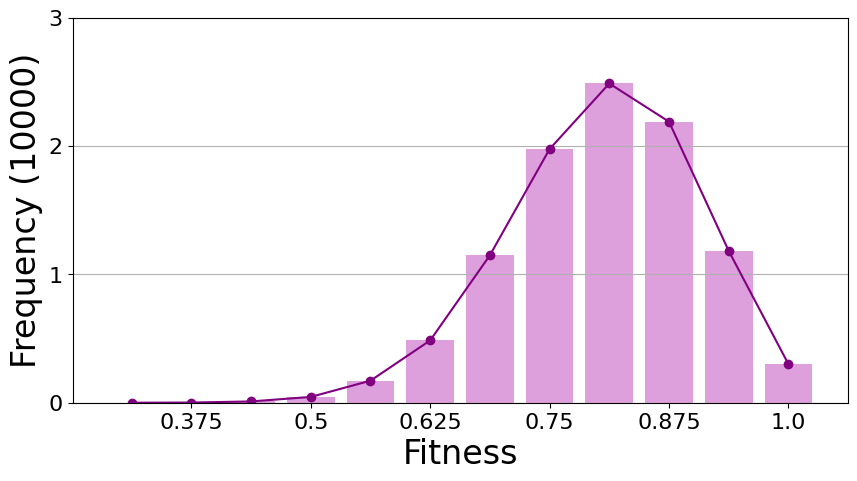

In [ ]:
geneticAlgorithm.showBarPlot(genome_id, samplingLength)

# Meta-parameters optimization

In [75]:
genotipo_lengths = [40,45,50,55,60]
mutation_rates = [0.05,0.1,0.15]
noise_ranges = [0.003,0]
lambda_vals = [6,8,10]
n = 10
combinations = product(genotipo_lengths, mutation_rates, noise_ranges, lambda_vals)

for combination in combinations:
    genotipo_length, mutation_rate, noise_range, lambda_val = combination
    
    executionTimes = []
    generationsCount = []
    arrivedMaxFitnessCount = 0
    
    genotypeLens = []
    startTime = datetime.datetime.now()
    for i in range(0,n):
        nGenes = genotipo_length
        nOutputs = 1
        nInputs = 6

        genoma = Genoma(nGenes,nInputs,nOutputs)
        genoma.setRateMutation(mutation_rate)
        genoma.setStochasticity(noise_range)

        geneticAlgorithm = GeneticAlgorithm()
        geneticAlgorithm.disableDisplay()
        geneticAlgorithm.setLambda(lambda_val)

        auxGenome = geneticAlgorithm.evolution(genoma,genoma.muxNand)
        lenI = auxGenome.getActiveZoneLen()
        while(lenI in genotypeLens):
            auxGenome = geneticAlgorithm.evolution(genoma,genoma.muxNand)
            lenI = auxGenome.getActiveZoneLen()
        genotypeLens.append(str(lenI))
    
        executionTimes.append(geneticAlgorithm.getTimeTaken())
        generationsCount.append(geneticAlgorithm.getTotalGeneration())
        arrivedMaxFitnessCount += 1 if geneticAlgorithm.gotMaxFitness == True else 0
    timeDiff = datetime.datetime.now() - startTime
    avgExecutionTime = sum(executionTimes)/n
    avgGenerationCount = sum(generationsCount)/n

    print(f"G.Length: {genotipo_length}, M.Rate: {mutation_rate}, N.Range: {noise_range}, Lambda: {lambda_val} - Average Execution Time: {avgExecutionTime}, Total Time Taken N dif Genotyopes Lens: {str(timeDiff)}, Average Generation Count: {avgGenerationCount}, Maximun Fitness Count: {arrivedMaxFitnessCount}")

G.Length: 40, M.Rate: 0.05, N.Range: 0.003, Lambda: 6 - Average Execution Time: 30.9433621, Total Time Taken N dif Genotyopes Lens: 0:05:09.433621, Average Generation Count: 4531.0, Maximun Fitness Count: 10
G.Length: 40, M.Rate: 0.05, N.Range: 0.003, Lambda: 8 - Average Execution Time: 19.4216174, Total Time Taken N dif Genotyopes Lens: 0:03:14.217170, Average Generation Count: 2275.5, Maximun Fitness Count: 10
G.Length: 40, M.Rate: 0.05, N.Range: 0.003, Lambda: 10 - Average Execution Time: 18.140783199999998, Total Time Taken N dif Genotyopes Lens: 0:03:01.407832, Average Generation Count: 1641.7, Maximun Fitness Count: 10
G.Length: 40, M.Rate: 0.05, N.Range: 0, Lambda: 6 - Average Execution Time: 20.285072, Total Time Taken N dif Genotyopes Lens: 0:03:22.851718, Average Generation Count: 2778.5, Maximun Fitness Count: 10
G.Length: 40, M.Rate: 0.05, N.Range: 0, Lambda: 8 - Average Execution Time: 29.867766100000004, Total Time Taken N dif Genotyopes Lens: 0:04:58.678664, Average Gene